# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

## Google Colab

First we'll download the data from Kaggle. For that let's follow the following [Stackoveflow answer](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)

In [2]:
# Let's run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asafam","key":"c4ea37f8767c3430e4d17c7cda57fd48"}\n'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Oct 16 06:51 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [2]:
# List available datasets.
!kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tristan581/17k-apple-app-store-strategy-games             17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16           3175         79  1.0              
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                       2MB  2019-08-12 16:24:45          33529        817  1.0              
gustavomodelli/forest-fires-in-brazil                     Forest Fires in Brazil                              31KB  2019-08-24 16:09:16           4375         95  0.9411765        
shuyangli94/food-com-recipes-and-user-interactions        Food.com Recipes and Interactions    

In [3]:
# Copy the MetroLyrics data set locally.
!kaggle datasets download -d gyani95/380000-lyrics-from-metrolyrics

100%|██████████████████████████████████████| 95.6M/95.6M [00:11<00:00, 8.90MB/s]
100%|██████████████████████████████████████| 95.6M/95.6M [00:11<00:00, 8.94MB/s]


In [1]:
!ls .

300features_40minwords_10context
380000-lyrics-from-metrolyrics.zip
DL_rnn_text_classification_generation.ipynb
DL_word_embedding_assignment.ipynb
README.md
environment.yml


In [0]:
!unzip 380000-lyrics-from-metrolyrics.zip

Archive:  380000-lyrics-from-metrolyrics.zip
replace lyrics.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!head lyrics.csv

## Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1478]:
import re
import pandas as pd
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [1479]:
# Load the data
raw_data = pd.read_csv("380000-lyrics-from-metrolyrics.zip")

Let's see the data

In [1480]:
raw_data.columns.values

array(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype=object)

In [1482]:
raw_data.shape

(362237, 6)

In [1483]:
print(raw_data.head(10))

   index                    song  year           artist genre  \
0      0               ego-remix  2009  beyonce-knowles   Pop   
1      1            then-tell-me  2009  beyonce-knowles   Pop   
2      2                 honesty  2009  beyonce-knowles   Pop   
3      3         you-are-my-rock  2009  beyonce-knowles   Pop   
4      4           black-culture  2009  beyonce-knowles   Pop   
5      5  all-i-could-do-was-cry  2009  beyonce-knowles   Pop   
6      6      once-in-a-lifetime  2009  beyonce-knowles   Pop   
7      7                 waiting  2009  beyonce-knowles   Pop   
8      8               slow-love  2009  beyonce-knowles   Pop   
9      9   why-don-t-you-love-me  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party 

In [1493]:
data['genre'].value_counts()

Rock          131377
Pop            49444
Hip-Hop        33965
Metal          28408
Other          23683
Country        17286
Jazz           17147
Electronic     16205
R&B             5935
Indie           5732
Folk            3241
Name: genre, dtype: int64

In [1498]:
print(data.shape)
data = raw_data.loc[raw_data["lyrics"].str.len() > 3]
print(data.shape)

(332423, 6)
(266505, 6)


In [1499]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/asaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1500]:
# Import various modules for string cleaning
import re
from nltk.corpus import stopwords

def document_to_words(text, remove_panctuations=True, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove panctuation marks
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # 2. Convert words to lower case and split them
    words = text.lower().split()
    #
    # 3. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]   
    #
    # 4. Return a list of words
    return words

In [1501]:
document_to_words(data["lyrics"][0], remove_stopwords=True)[:10]

['oh',
 'baby',
 'know',
 'gonna',
 'cut',
 'right',
 'chase',
 'women',
 'made',
 'like']

In [1502]:
import nltk
nltk.download('punkt')

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /Users/asaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1503]:
tokenizer.tokenize(data["lyrics"][0].strip())

['Oh baby, how you doing?',
 "You know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you?",
 "You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy?",
 "Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what 

In [1504]:
# Define a function to split a document into parsed sentences
def document_to_sentences(document, tokenizer, remove_stopwords=False):
    # Function to split a document into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(document) if tokenizer else document
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(document_to_words(raw_sentence, remove_stopwords))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [1505]:
sentence = document_to_sentences(data["lyrics"][0], tokenizer, remove_stopwords=True)
len(sentence[1])

37

In [1506]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for song_lyrics in data["lyrics"]:
    sentences += document_to_sentences(song_lyrics, tokenizer, 
                                       remove_stopwords=True)

Parsing sentences from training set


In [1507]:
print(sentences[:3])

[['oh', 'baby', 'how', 'you', 'doing'], ['you', 'know', 'i', 'm', 'gonna', 'cut', 'right', 'to', 'the', 'chase', 'some', 'women', 'were', 'made', 'but', 'me', 'myself', 'i', 'like', 'to', 'think', 'that', 'i', 'was', 'created', 'for', 'a', 'special', 'purpose', 'you', 'know', 'what', 's', 'more', 'special', 'than', 'you'], ['you', 'feel', 'me', 'it', 's', 'on', 'baby', 'let', 's', 'get', 'lost', 'you', 'don', 't', 'need', 'to', 'call', 'into', 'work', 'cause', 'you', 're', 'the', 'boss', 'for', 'real', 'want', 'you', 'to', 'show', 'me', 'how', 'you', 'feel', 'i', 'consider', 'myself', 'lucky', 'that', 's', 'a', 'big', 'deal', 'why']]


In [1509]:
from gensim.models import Word2Vec

def word2vec(sentences, num_features=300, min_word_count=40, workers=4, 
             context=10, downsampling=1e-3, save_model=True):

  # Initialize and train the model (this will take some time)
  print("Training model...")
  model = Word2Vec(sentences,
                   workers=workers,
                   size=num_features, 
                   min_count=min_word_count,
                   window=context, 
                   sample=downsampling)

  if save_model:
    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model_name = "{}features_{}minwords_{}context.wv.model".format(num_features, 
                                                          min_word_count, 
                                                          context)
    model.save(model_name)
 
  return model

In [1510]:
word2vec(sentences) # uncomment if we want to build the model file

INFO - 21:17:22: collecting all words and their counts
INFO - 21:17:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


INFO - 21:17:22: PROGRESS: at sentence #10000, processed 547073 words, keeping 24856 word types
INFO - 21:17:22: PROGRESS: at sentence #20000, processed 1002175 words, keeping 36701 word types
INFO - 21:17:23: PROGRESS: at sentence #30000, processed 1577546 words, keeping 45437 word types
INFO - 21:17:23: PROGRESS: at sentence #40000, processed 2132629 words, keeping 55005 word types
INFO - 21:17:23: PROGRESS: at sentence #50000, processed 2565209 words, keeping 60035 word types
INFO - 21:17:23: PROGRESS: at sentence #60000, processed 3125605 words, keeping 70378 word types
INFO - 21:17:23: PROGRESS: at sentence #70000, processed 3650087 words, keeping 80685 word types
INFO - 21:17:24: PROGRESS: at sentence #80000, processed 4152681 words, keeping 88085 word types
INFO - 21:17:24: PROGRESS: at sentence #90000, processed 4712834 words, keeping 92527 word types
INFO - 21:17:24: PROGRESS: at sentence #100000, processed 5346594 words, keeping 95618 word types
INFO - 21:17:24: PROGRESS: at 

INFO - 21:17:38: PROGRESS: at sentence #840000, processed 44667279 words, keeping 330357 word types
INFO - 21:17:38: PROGRESS: at sentence #850000, processed 45114992 words, keeping 331606 word types
INFO - 21:17:39: PROGRESS: at sentence #860000, processed 45840735 words, keeping 334894 word types
INFO - 21:17:39: PROGRESS: at sentence #870000, processed 46364336 words, keeping 338759 word types
INFO - 21:17:39: PROGRESS: at sentence #880000, processed 46858701 words, keeping 340849 word types
INFO - 21:17:39: PROGRESS: at sentence #890000, processed 47371857 words, keeping 345358 word types
INFO - 21:17:40: PROGRESS: at sentence #900000, processed 47954498 words, keeping 346951 word types
INFO - 21:17:40: PROGRESS: at sentence #910000, processed 48459183 words, keeping 351406 word types
INFO - 21:17:40: PROGRESS: at sentence #920000, processed 48891710 words, keeping 353783 word types
INFO - 21:17:40: PROGRESS: at sentence #930000, processed 49400367 words, keeping 355945 word types


INFO - 21:18:34: EPOCH 1 - PROGRESS: at 72.88% examples, 832401 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:35: EPOCH 1 - PROGRESS: at 74.68% examples, 832533 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:36: EPOCH 1 - PROGRESS: at 76.71% examples, 833078 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:37: EPOCH 1 - PROGRESS: at 78.78% examples, 833347 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:38: EPOCH 1 - PROGRESS: at 80.73% examples, 833896 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:39: EPOCH 1 - PROGRESS: at 82.67% examples, 834646 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:40: EPOCH 1 - PROGRESS: at 84.62% examples, 835207 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:41: EPOCH 1 - PROGRESS: at 86.16% examples, 835475 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:42: EPOCH 1 - PROGRESS: at 87.77% examples, 835687 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:43: EPOCH 1 - PROGRESS: at 89.86% examples, 835845 words/s, in_qsize 7, out_qsize 0
INFO - 21:18:44: EPOCH 1 - PRO

INFO - 21:19:52: EPOCH 3 - PROGRESS: at 10.71% examples, 529976 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:53: EPOCH 3 - PROGRESS: at 11.74% examples, 523302 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:54: EPOCH 3 - PROGRESS: at 12.90% examples, 521698 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:55: EPOCH 3 - PROGRESS: at 14.35% examples, 534500 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:56: EPOCH 3 - PROGRESS: at 15.85% examples, 547196 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:57: EPOCH 3 - PROGRESS: at 17.62% examples, 561164 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:58: EPOCH 3 - PROGRESS: at 19.42% examples, 577103 words/s, in_qsize 7, out_qsize 0
INFO - 21:19:59: EPOCH 3 - PROGRESS: at 20.79% examples, 580333 words/s, in_qsize 6, out_qsize 1
INFO - 21:20:00: EPOCH 3 - PROGRESS: at 22.31% examples, 586151 words/s, in_qsize 7, out_qsize 0
INFO - 21:20:01: EPOCH 3 - PROGRESS: at 23.85% examples, 590216 words/s, in_qsize 7, out_qsize 0
INFO - 21:20:02: EPOCH 3 - PRO

INFO - 21:21:14: EPOCH 4 - PROGRESS: at 26.88% examples, 601873 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:15: EPOCH 4 - PROGRESS: at 28.78% examples, 613060 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:16: EPOCH 4 - PROGRESS: at 30.39% examples, 620013 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:17: EPOCH 4 - PROGRESS: at 31.90% examples, 622485 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:18: EPOCH 4 - PROGRESS: at 33.95% examples, 631769 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:19: EPOCH 4 - PROGRESS: at 35.84% examples, 640275 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:20: EPOCH 4 - PROGRESS: at 37.49% examples, 648368 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:21: EPOCH 4 - PROGRESS: at 39.15% examples, 655375 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:22: EPOCH 4 - PROGRESS: at 41.01% examples, 662610 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:23: EPOCH 4 - PROGRESS: at 42.94% examples, 669518 words/s, in_qsize 7, out_qsize 0
INFO - 21:21:24: EPOCH 4 - PRO

INFO - 21:22:37: EPOCH 5 - PROGRESS: at 70.23% examples, 777508 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:38: EPOCH 5 - PROGRESS: at 71.76% examples, 777903 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:39: EPOCH 5 - PROGRESS: at 73.37% examples, 776106 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:40: EPOCH 5 - PROGRESS: at 75.07% examples, 776337 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:41: EPOCH 5 - PROGRESS: at 76.37% examples, 771109 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:42: EPOCH 5 - PROGRESS: at 78.15% examples, 770526 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:43: EPOCH 5 - PROGRESS: at 79.88% examples, 768306 words/s, in_qsize 6, out_qsize 1
INFO - 21:22:44: EPOCH 5 - PROGRESS: at 81.14% examples, 765403 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:45: EPOCH 5 - PROGRESS: at 82.84% examples, 764510 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:46: EPOCH 5 - PROGRESS: at 84.33% examples, 762571 words/s, in_qsize 7, out_qsize 0
INFO - 21:22:47: EPOCH 5 - PRO

In [1511]:
w2v_model = Word2Vec.load("300features_40minwords_10context.wv.model")

INFO - 21:26:29: loading Word2Vec object from 300features_40minwords_10context.wv.model
INFO - 21:26:30: loading wv recursively from 300features_40minwords_10context.wv.model.wv.* with mmap=None
INFO - 21:26:30: setting ignored attribute vectors_norm to None
INFO - 21:26:30: loading vocabulary recursively from 300features_40minwords_10context.wv.model.vocabulary.* with mmap=None
INFO - 21:26:30: loading trainables recursively from 300features_40minwords_10context.wv.model.trainables.* with mmap=None
INFO - 21:26:30: setting ignored attribute cum_table to None
INFO - 21:26:30: loaded 300features_40minwords_10context.wv.model


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [1512]:
w2v_model.wv.most_similar("dog") 

INFO - 21:26:33: precomputing L2-norms of word weight vectors


[('hound', 0.6072163581848145),
 ('puppy', 0.5779114961624146),
 ('cat', 0.5628559589385986),
 ('barkin', 0.5582836270332336),
 ('barking', 0.5339473485946655),
 ('frog', 0.5248117446899414),
 ('doggy', 0.5087523460388184),
 ('bark', 0.5061835050582886),
 ('hog', 0.5035767555236816),
 ('dogs', 0.5019047260284424)]

In [1513]:
w2v_model.wv.most_similar("love") 

[('baby', 0.555811882019043),
 ('loving', 0.5440404415130615),
 ('heart', 0.522280216217041),
 ('oh', 0.4947924017906189),
 ('true', 0.48665851354599),
 ('you', 0.48389655351638794),
 ('unconditional', 0.48382511734962463),
 ('darling', 0.47346723079681396),
 ('lovin', 0.4705849885940552),
 ('darlin', 0.4701448380947113)]

In [1514]:
w2v_model.wv.most_similar("war") 

[('battle', 0.6661872863769531),
 ('wars', 0.6377437114715576),
 ('waged', 0.629664421081543),
 ('waging', 0.6170507669448853),
 ('civil', 0.5605376958847046),
 ('battlefield', 0.536693811416626),
 ('warfare', 0.5238355398178101),
 ('fighting', 0.5131027698516846),
 ('tug', 0.5119432210922241),
 ('battles', 0.5112775564193726)]

In [1515]:
w2v_model.wv.most_similar("blue") 

[('bluest', 0.5243340730667114),
 ('gray', 0.5117449760437012),
 ('grey', 0.4957510530948639),
 ('hue', 0.44540661573410034),
 ('cloudless', 0.4412332773208618),
 ('misty', 0.4387950301170349),
 ('starry', 0.4387114644050598),
 ('cloudy', 0.4215405583381653),
 ('green', 0.41407644748687744),
 ('red', 0.41392406821250916)]

In [1516]:
w2v_model.wv.most_similar("paris") 

[('france', 0.6714458465576172),
 ('hilton', 0.6198512315750122),
 ('spain', 0.6048012375831604),
 ('italy', 0.5840489268302917),
 ('tokyo', 0.5763559937477112),
 ('london', 0.5726921558380127),
 ('venice', 0.5575970411300659),
 ('rome', 0.5369668006896973),
 ('miami', 0.5305115580558777),
 ('milan', 0.5288726687431335)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [1517]:
w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6248096227645874),
 ('kings', 0.42998164892196655),
 ('crowning', 0.4081261157989502),
 ('crown', 0.399611234664917),
 ('homecoming', 0.39911770820617676),
 ('goddess', 0.3796178102493286),
 ('crowned', 0.3766542077064514),
 ('reigning', 0.3633894622325897),
 ('throne', 0.36280179023742676),
 ('princess', 0.36060717701911926)]

In [1518]:
w2v_model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('queen', 0.9129402041435242),
 ('homecoming', 0.7548413276672363),
 ('crowning', 0.749069094657898),
 ('crown', 0.7434477806091309),
 ('kings', 0.7417984008789062),
 ('goddess', 0.7413286566734314),
 ('princess', 0.7282884120941162),
 ('beauty', 0.7236695885658264),
 ('latifah', 0.7194628715515137),
 ('newborn', 0.719289243221283)]

In [1520]:
vector = w2v_model.wv['king'] - w2v_model.wv['man'] + w2v_model.wv['woman']
w2v_model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('king', 0.7157250046730042),
 ('queen', 0.6248096227645874),
 ('kings', 0.4299815893173218),
 ('crowning', 0.4081261157989502),
 ('crown', 0.3996112644672394),
 ('homecoming', 0.39911770820617676),
 ('goddess', 0.3796178102493286),
 ('crowned', 0.3766542077064514),
 ('woman', 0.3646465539932251),
 ('reigning', 0.3633894622325897)]

In [1521]:
# Cosine similarity
cosine_distance = w2v_model.wv.similarity("woman", "girl")
print("Cosine distance = ", cosine_distance)

import numpy as np
euclidean_distance = np.linalg.norm(w2v_model.wv["women"] - w2v_model.wv["girl"])
print("Euclidean distance = ", euclidean_distance)

Cosine distance =  0.54114074
Euclidean distance =  1.3017702


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [1522]:
!ls .

300features_40minwords_10context.wv.model
380000-lyrics-from-metrolyrics.zip
DL_rnn_text_classification_generation.ipynb
DL_word_embedding_assignment.ipynb
README.md
best-model.model
best-model.pt
cnn.py
environment.yml
test.csv
train.csv
val.csv


## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

In [1525]:
# Let's first filter all songs with no genre (null or have "Not Available" genre)
data = data[data["genre"] != "Not Available"]
data = data[data["genre"].notnull()]
data

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...,...
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


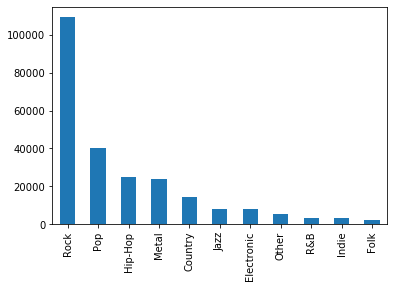

In [1528]:
data['genre'].value_counts().plot.bar()

In [1529]:
# Import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
genres_encoded = le.fit_transform(data["genre"].tolist())
genres_encoded

array([8, 8, 8, ..., 0, 0, 0])

In [1530]:
classes = list(le.classes_)
codes = le.transform(list(le.classes_))
for clss, code in zip(classes, codes):
  print(clss, code)

Country 0
Electronic 1
Folk 2
Hip-Hop 3
Indie 4
Jazz 5
Metal 6
Other 7
Pop 8
R&B 9
Rock 10


### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [1531]:
from sklearn.model_selection import train_test_split

# Split songs dataset to train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(data["lyrics"].values,
                                                    genres_encoded, 
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [1532]:
X_train.shape

(155251,)

In [1533]:
def clean_X(X):
    clean_X = []

    # Loop over each document; create an index i that goes from 0 to the length
    # of the train list 
    for i, val in enumerate(X):
        # Call our function for each one, and add the result to the list of clean reviews
        if ((i + 1) % 50000 == 0):
            print("Lyrics %d of %d\n" % (i + 1, X.size))
        clean_X.append(" ".join(document_to_words(val)))
  
    return clean_X

In [1534]:
clean_X_train = clean_X(X_train)

Lyrics 50000 of 155251

Lyrics 100000 of 155251

Lyrics 150000 of 155251



In [1535]:
clean_X_train[:3]

['if i didn t already love you i d fall in love tonight',
 'i m a game that you used to play and i m a plan that you didn t lay so well and i m a fire that burns in your mind so close your eyes i m a memory i m a love that you bought for a song and i m a voice on a green telephone and i m a day that lasted so long so close your eyes i m a memory i m a dream that comes with the night and i m a face that fades with the light and i m a tear that falls out of sight so close your eyes i m a memory i m a love that you bought for a song and i m a voice on a green telephone and i m a day that lasted so long so close your eyes i m a memory',
 'you say your hurting is over it feels like you re back from the dead but still i can t believe it s over and i can t get your sight your scent from my head it seems like these moments are lasting forever the times when we felt alive you carried my heart in the midst of this battle in your hands this time i won t try to reach you you re already too far gon

In [1536]:
clean_X_test = clean_X(X_train)

Lyrics 50000 of 155251

Lyrics 100000 of 155251

Lyrics 150000 of 155251



In [1537]:
def vectorize_features(X, vectorizer):
      # fit_transform() does two functions: First, it fits the model
      # and learns the vocabulary; second, it transforms our training data
      # into feature vectors. The input to fit_transform should be a list of 
      # strings.
    features = vectorizer.fit_transform(X)

      # Numpy arrays are easy to work with, so convert the result to an 
      # array
    features = features.toarray()
    return features

In [1538]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) 

X_train_features = vectorize_features(X_train, vectorizer)
X_test_features = vectorize_features(X_test, vectorizer)

In [1539]:
# See how the Vectorizer works
features = vectorizer.fit_transform(['i eat the banana in the summer', 'in the spring i ate bananas'])
print(features.toarray())
print(vectorizer.get_feature_names())

[[0 1 0 1 1 0 1 2]
 [1 0 1 0 1 1 0 1]]
['ate', 'banana', 'bananas', 'eat', 'in', 'spring', 'summer', 'the']


In [1540]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Gaussian Classifier
nbc = MultinomialNB()

#Train the model using the training sets
nbc.fit(X_train_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [1541]:
#Predict the response for test dataset
y_pred = nbc.predict(X_test_features)

Show the confusion matrix.

In [1542]:
print(X_test_features.shape)
print(y_test.shape)
print(len(y_pred))

(48516, 5000)
(48516,)
48516


In [1543]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[    0    28   780   478     4     8     6  1524     1     0    25]
 [    2    22   306   325     4    13    25   771     5     1   100]
 [    0    11   109    72     0     2     6   168     3     0    34]
 [    1    21  1240  1230     0     8    24  2409     5     0    37]
 [    1     9   133   105     0     4     2   353     1     0     8]
 [    0    17   343   325     3     5     8   868     1     0    44]
 [    2    64  1269  1024     5    18    49  2127    14     0   249]
 [    1    18   212   255     3     6     6   592     5     0     9]
 [    3   130  1458  1552    18    30    64  4715    20     0    99]
 [    0    10   101   115     0     2     4   447     0     0     4]
 [    4   270  4836  3980    52    95   167 11746    45     0   583]]


Show the classification report - precision, recall, f1 for each class.

In [1544]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Country       0.00      0.00      0.00      2854
  Electronic       0.04      0.01      0.02      1574
        Folk       0.01      0.27      0.02       405
     Hip-Hop       0.13      0.25      0.17      4975
       Indie       0.00      0.00      0.00       616
        Jazz       0.03      0.00      0.01      1614
       Metal       0.14      0.01      0.02      4821
       Other       0.02      0.53      0.04      1107
         Pop       0.20      0.00      0.00      8089
         R&B       0.00      0.00      0.00       683
        Rock       0.49      0.03      0.05     21778

    accuracy                           0.05     48516
   macro avg       0.10      0.10      0.03     48516
weighted avg       0.28      0.05      0.04     48516



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [1545]:
import numpy as np

def avg_word_vector(X):
    avg_vectors = [];
    # todo: can be better implemented with numpy
    for i, val in enumerate(X):
        total_vector = np.zeros(w2v_model.vector_size)
        words = val.split(" ")
        for word in words:
            total_vector += w2v_model[word] if word in w2v_model.wv.vocab else np.zeros(w2v_model.vector_size) 
        avg_vector = total_vector / len(words)
        avg_vectors.append(avg_vector)
    return avg_vectors

In [1546]:
X_train_avg_vc = avg_word_vector(X_train)
X_test_avg_vc = avg_word_vector(X_test)

/anaconda3/envs/biu-python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [1547]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train_avg_vc)  
X_train_avg_vc_scaled = scaler.transform(X_train_avg_vc)  
# apply same transformation to test data
X_test_avg_vc_scaled = scaler.transform(X_test_avg_vc) 

In [1548]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(50,))

#Train the model using the training sets
clf.fit(X_train_avg_vc_scaled, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_avg_vc_scaled)

/anaconda3/envs/biu-python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [1549]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[  858     4     2    16     0    61    15     2   339     0  1557]
 [   14    54     0    82     0     8    72     2   315     0  1027]
 [   22     1    33     6     0     2    16     1    47     0   277]
 [   17    24     0  3415     0     4    41    11   504     1   958]
 [   18     1     0     9     2     3    10     1    79     0   493]
 [  114     5     0    28     0   214    16    19   329     0   889]
 [   12    16     0    81     0     4  2273     1   148     2  2284]
 [   33     7     3   101     0    70    33    29   269     1   561]
 [  183    30     5   290     0    86   134    21  2909     0  4431]
 [   12     3     0    28     0    12    10     0   186     1   431]
 [  620    67     9   322     0   149   826    26  2528     5 17226]]


In [1550]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Country       0.45      0.30      0.36      2854
  Electronic       0.25      0.03      0.06      1574
        Folk       0.63      0.08      0.14       405
     Hip-Hop       0.78      0.69      0.73      4975
       Indie       1.00      0.00      0.01       616
        Jazz       0.35      0.13      0.19      1614
       Metal       0.66      0.47      0.55      4821
       Other       0.26      0.03      0.05      1107
         Pop       0.38      0.36      0.37      8089
         R&B       0.10      0.00      0.00       683
        Rock       0.57      0.79      0.66     21778

    accuracy                           0.56     48516
   macro avg       0.49      0.26      0.28     48516
weighted avg       0.54      0.56      0.52     48516



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [1551]:
X = clean_X(data["lyrics"].values)
X[:3]

Lyrics 50000 of 242580

Lyrics 100000 of 242580

Lyrics 150000 of 242580

Lyrics 200000 of 242580



['oh baby how you doing you know i m gonna cut right to the chase some women were made but me myself i like to think that i was created for a special purpose you know what s more special than you you feel me it s on baby let s get lost you don t need to call into work cause you re the boss for real want you to show me how you feel i consider myself lucky that s a big deal why well you got the key to my heart but you ain t gonna need it i d rather you open up my body and show me secrets you didn t know was inside no need for me to lie it s too big it s too wide it s too strong it won t fit it s too much it s too tough he talk like this cause he can back it up he got a big ego such a huge ego i love his big ego it s too much he walk like this cause he can back it up usually i m humble right now i don t choose you can leave with me or you could have the blues some call it arrogant i call it confident you decide when you find on what i m working with damn i know i m killing you with them l

In [1552]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5)

X_tfidf = vectorizer.fit_transform(X)

In [1553]:
print(type(X_tfidf[0]))

<class 'scipy.sparse.csr.csr_matrix'>


In [1554]:
from sklearn.model_selection import train_test_split

# Split songs dataset to train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,
                                                    genres_encoded, 
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [1555]:
X_train[:100].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1556]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(5,))

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

/anaconda3/envs/biu-python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [1557]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 1073    20    26    59    27   141    67    34   341    51  1015]
 [   43   221     8   112    20    27   117    38   282    15   691]
 [   28     4    48    12    15    14    23    16    61     4   180]
 [   63    92    13  3375    10    57   106    71   454    59   675]
 [   32    11     4    24    47     9    32    18    95     8   336]
 [  159    10    13    75     9   414    24    80   266    31   533]
 [  100   119    22   217    76    31  2211    42   313    31  1659]
 [   41    34    10   107    21   134    45   106   234     7   368]
 [  364   210    44   451    97   229   316   147  3174    71  2986]
 [   42     8     4    62     2    35    28     8   138    82   274]
 [ 1257   446   175   830   335   500  1602   342  2868   212 13211]]


In [1558]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Country       0.34      0.38      0.35      2854
  Electronic       0.19      0.14      0.16      1574
        Folk       0.13      0.12      0.12       405
     Hip-Hop       0.63      0.68      0.66      4975
       Indie       0.07      0.08      0.07       616
        Jazz       0.26      0.26      0.26      1614
       Metal       0.48      0.46      0.47      4821
       Other       0.12      0.10      0.11      1107
         Pop       0.39      0.39      0.39      8089
         R&B       0.14      0.12      0.13       683
        Rock       0.60      0.61      0.60     21778

    accuracy                           0.49     48516
   macro avg       0.30      0.30      0.30     48516
weighted avg       0.49      0.49      0.49     48516



### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [1376]:
!ls .

300features_40minwords_10context
380000-lyrics-from-metrolyrics.zip
DL_rnn_text_classification_generation.ipynb
DL_word_embedding_assignment.ipynb
README.md
best-model.pt
cnn.py
environment.yml
temp.md
temp.md.pt
test.csv
train.csv
val.csv


In [1382]:
raw_data = pd.read_csv('380000-lyrics-from-metrolyrics.zip')

In [1384]:
# all data that is not null
data = raw_data[raw_data['lyrics'].notnull()]

In [143]:
!pip install torchtext

     |████████████████████████████████| 61kB 444kB/s eta 0:00:011


#### Load the data

In [136]:
from sklearn.model_selection import train_test_split

# Split songs dataset to train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(data["lyrics"].values,
                                                    data["genre"].values, 
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [229]:
X_train[0]

"It must be summer\n'Cause the days are long\nAnd I dial your number\nBut you're gone, gone, gone\nI'd set out searching\nBut the car won't start\nAnd it must be summer\n'Cause I'm falling apart\nI try your sister\nOn the Jersey Shore\nShe said you might be stopping by\nBut she's not sure\nSo I call your mother\nOn Long Island Sound\nShe said it must be summer\n'Cause you're never around\nAnd the sun is beating me senseless\nI feel defenseless like a dying lamb\nI don't wan't to lie by the oceanside\nDon't want to play in the sand\nCan't you understand?\nCan't you understand?\nIt must be summer\n'Cause the streets are bare\nAnd I try your number\nBut you're just not there\nAnd the sun keeps shining\n'Til it's dead and gone\nAnd it must be summer\n'Cause I can't go on"

In [245]:
import pandas as pd

train_df = pd.DataFrame({'lyrics': X_train, 'genre': y_train})
test_df = pd.DataFrame({'lyrics': X_test, 'genre': y_test})
val_df = pd.DataFrame({'lyrics': X_val, 'genre': y_val})

train_df.to_csv(r'train.csv')
test_df.to_csv(r'test.csv')
val_df.to_csv(r'val.csv')

In [246]:
!ls .

300features_40minwords_10context
380000-lyrics-from-metrolyrics.zip
DL_rnn_text_classification_generation.ipynb
DL_word_embedding_assignment.ipynb
README.md
cnn.py
environment.yml
test.csv
train.csv
val.csv


In [250]:
print(train_df)

                                                   lyrics    genre
0       It must be summer\n'Cause the days are long\nA...     Rock
1       Mug mug mug\nCoffee mug\nGonna clear the haze\...     Rock
2       We stepped together in the river\nWe traded fe...     Rock
3       Alright Im gonna show ya how different I am\nE...     Rock
4       - this crime - for him\n- desire - noone\n- se...     Rock
...                                                   ...      ...
170558  I couldn't think of someone that Id rather see...     Rock
170559  Virgil Caine is the name, and I served on the ...     Rock
170560  The reason why I've called us all together\nIs...  Country
170561  California's burning, burning\nBurning to the ...     Rock
170562  I've got a secret.\nIt's on the tip of my tong...    Metal

[170563 rows x 2 columns]


In [331]:
# add <pad> special word to the dictionary
PAD = "<pad>"
w2v_model.wv["<pad>"] = np.zeros(300,)

In [ ]:
!python -m spacy download en_core_web_sm

In [378]:
import spacy
spacy_en = spacy.load('en')

In [817]:
import re
from nltk.corpus import stopwords

def process_document(text, remove_panctuations=True, 
                        remove_stopwords=True, remove_unknown_words=True, padding=300):
    
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]  
        
    if remove_unknown_words:
        words = [w for w in words if w in w2v_model.wv]  
    
    if len(words) < padding:
        words += ([PAD] * (padding - len(words)))
    elif len(words) > padding:
        words = words[:padding]
        
#     processed_document = " ".join(words)
    return words

In [818]:
from sklearn.preprocessing import LabelBinarizer
ohe = LabelBinarizer()
ohe.fit_transform(data['genre'].values)

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [766]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import spacy

class CustomDatasetFromDF(Dataset):
    def __init__(self, df):
        self.texts = df['lyrics'].values
        self.labels = df['genre'].values

    def __getitem__(self, index):
        text = self.texts[index]
        text = spacy_en.tokenizer(process_document(text))

        label = self.labels[index]
        label = ohe.transform([label])[0]

        return text, label

    def __len__(self):
        return len(self.labels)


dataset = CustomDatasetFromDF(data)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print("dataset_size = ", len(dataset))
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train = SubsetRandomSampler(train_indices)
val = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


dataset_size =  266505


In [767]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=64, device=0)

AttributeError: 'SubsetRandomSampler' object has no attribute 'sort_key'

In [740]:
w2v_model.wv.save_word2vec_format("./model2.wv.moded")

INFO - 04:51:32: storing 29974x300 projection weights into ./temp.md


In [741]:
from torchtext.vocab import Vectors
vectors = Vectors(name="temp.md", cache='.')

INFO - 04:51:42: Loading vectors from ./temp.md.pt


In [761]:
from torch.utils.data import Dataset, Subset, DataLoader

class SongsDataset(data.Dataset):
    
    name = 'Songs'
    df = data

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [(None, None), ('text', text_field), ('label', label_field)]
        examples = []

        for index, row in df.iterrows():
            text = row['lyrics']
            label = row['genre']
            examples.append(data.Example.fromlist([text, label], fields))

        super(SongsDataset, self).__init__(examples, fields, **kwargs)

#     @classmethod
#     def splits(cls, text_field, label_field, root='.data',
#                train='train', test='test', **kwargs):
#         return super(SongsDataset, cls).splits(
#             root=root, text_field=text_field, label_field=label_field,
#             train=train, validation=None, test=test, **kwargs)


    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        def tokenizer(text): # create a tokenizer function
            return [tok.text for tok in spacy_en.tokenizer(process_document(text))]
        
        TEXT = data.Field(toknizer=tokenizer, fix_length=128)
        LABEL = data.Field(sequential=False)

        train, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)

        return data.BucketIterator.splits((train, test), batch_size=batch_size, device=device)

In [762]:
# set up fields
def tokenizer(text): # create a tokenizer function
            return [tok.text for tok in spacy_en.tokenizer(process_document(text))]

def one_hot_encoding(label):
    vec = ohe.transform([label])[0]
    return vec

TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=128)
LABEL = data.Field(sequential=False, preprocessing=one_hot_encoding)

# make splits for data
# train, test = SongsDataset.splits(TEXT, LABEL)
master = SongsDataset(data, TEXT, LABEL)  # your "master" dataset
n = len(master)  # how many total elements you have
n_test = int( n * .2 )  # number of test/val elements
n_train = n - 2 * n_test
idx = list(range(n))  # indices to all elements
random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
train_idx = idx[:n_train]
val_idx = idx[n_train:(n_train + n_test)]
test_idx = idx[(n_train + n_test):]

train = Subset(master, train_idx)
val = Subset(master, val_idx)
test = Subset(master, test_idx)

# build the vocabulary
TEXT.build_vocab(train, vectors=vectors)
LABEL.build_vocab(train)

# make iterator for splits
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=64, device=0)

TypeError: 'Example' object is not iterable

In [662]:
import torch
from torchtext import data
from torchtext import datasets
import random
import spacy

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(process_document(text))]

def one_hot_encoding(label):
    vec = ohe.transform([label])[0]
    return vec

TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=128)
LABEL = data.Field(sequential=False, preprocessing=one_hot_encoding)

train_data, val_data, test_data = data.TabularDataset.splits(
    path='.', 
    train='train.csv',
    validation='val.csv', 
    test='test.csv', 
    format='csv',
    fields=[(None, None), ('lyrics', TEXT), ('genre', LABEL)],
    skip_header=True
)

In [665]:
TEXT.build_vocab(
            tra,
            vectors=vectors
)
LABEL.build_vocab(test_data)

In [776]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, val_data), 
                                                                           batch_size = BATCH_SIZE)

AttributeError: 'Subset' object has no attribute 'sort_key'

In [1436]:
import re
from nltk.corpus import stopwords

def process_document(text, remove_panctuations=True, 
                        remove_stopwords=True, remove_unknown_words=True, padding=128):
    
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w.lower() in stops]  
        
    if remove_unknown_words:
        words = [w for w in words if w in w2v_model.wv]  
    
    if len(words) < padding:
        words += ([PAD] * (padding - len(words)))
    elif len(words) > padding:
        words = words[:padding]
        
#     processed_document = " ".join(words)
    return words

In [1437]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return process_document(text) #[tok.text for tok in spacy_en.tokenizer(process_document(text))]

In [1438]:
from sklearn.preprocessing import LabelBinarizer
ohe = LabelBinarizer()
ohe.fit_transform(data['genre'].values)

def one_hot_encoding(label):
    vec = ohe.transform([label])[0]
    return vec



# Import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
genres_encoded = le.fit_transform(data["genre"])
genres_encoded

array([9, 9, 9, ..., 0, 0, 0])

In [1439]:
le.fit_transform(["Rock"])

array([0])

In [1463]:
from torch.utils.data import Dataset, DataLoader, random_split

In [1464]:
class SongsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df):
        """
        Args:
            df (pandas.DataFrame): DataFrame object
        """
        self.texts = df['lyrics'].values
        self.labels = df['genre'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        text = tokenizer(text)
        text = [w2v_model.wv.vocab[word].index for word in text]
        label = self.labels[idx]
        label = one_hot_encoding(label)

        sample = (torch.tensor(text), torch.tensor(label, dtype=torch.float))

        return sample

In [1465]:
w2v_model.wv.vocab['dog'].index

690

In [1466]:
dataset = SongsDataset(data)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

In [1467]:
dataset.__getitem__(99)

(tensor([   38,   200,   244,   217,   152, 24898,   137,   270,   217,   152,
           137,   270,   217,   152,   137,   152,   137,   270,   217,   152,
           137,   152,   137,   290,   342,   399,   399,   362,    72,   314,
           314,   270,   217,   152,   137,   217,   152,   137,   270,   217,
           152,   137,   152,   137, 19839,  7963,  1185,   226,   226,   305,
         13469,   270,   140,   140,   270,   217,   152,   137,    91,  1914,
           305,   377,    57,    53,   725, 11797,   150,   180,  2624,    66,
            57,  1844,   156,    38,   816,   463,    66,    30,   499,   566,
            66,   343,  1116,    66,  5091,    38,    48,    66,   170,   290,
           631,    52,    48,   139,   725,   150,   301,    66,   967,    38,
           967,    66,    91,   290,   131,   150,  3957,    66,   491,   131,
            38,    66,    38,    38,   270,    38,    38,   217,    38,   152,
            38,   137,    38,   270,   217,   152,  

In [1468]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)


#### Functions to train and evaluate the model

In [1469]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    
    probs = torch.softmax(preds, dim=1)
    winners = probs.argmax(dim=1)
    correct = (winners == y.argmax(dim=1)).float() #convert into float for division 

    acc = correct.sum() / len(correct)
    return acc

In [1470]:
def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
#     for batch in iterator:
    for index, batch in enumerate(loader):
        
        optimizer.zero_grad()
        
        predictions = model(batch[0]).squeeze(1)
        
        loss = criterion(predictions, batch[1])
        
        acc = binary_accuracy(predictions, batch[1])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [1471]:
def evaluate(model, loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
#         for batch in iterator:
        for index, batch in enumerate(loader):

            predictions = model(batch[0]).squeeze(1)
            
            loss = criterion(predictions, batch[1])
            
            acc = binary_accuracy(predictions, batch[1])

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [1472]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Define the model

In [1473]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, out_channels, kernel_sizes, dropout, weights, 
                 freeze_embeddings=True):
        """
        Arguments
        ---------
        output_size : 2 = (pos, neg)
        in_channels : Number of input channels. Here it is 1 as the input data has dimension = (batch_size, num_seq, embedding_length)
        output_dim : Number of output channels after convolution operation performed on the input matrix (also number of filters)
        kernel_sizes : A list consisting of 3 different kernel_sizes. Convolution will be performed 3 times and finally results from each kernel_size will be concatenated.
        dropout : Probability of retaining an activation node during dropout operation
        vocab_size : Size of the vocabulary containing unique words
        embedding_dim : Embedding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table
        freeze_embeddings: Boolean flag to unfreeze the word embeddings weights
        --------
            
        """
        super(CNNClassifier, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        
        if weights is not None:
            print(w2v_model.wv.vectors.shape)
            self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(weights), freeze=freeze_embeddings)
#             self.word_embeddings.weight = nn.Parameter(weights) # using pre-trained weights
#             self.word_embeddings.weight.requires_grad=unfreeze_embeddings
        else:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels = 1,
                      out_channels = out_channels,
                      kernel_size = (embedding_dim, ks)
                     ) for ks in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, output_size)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input) # conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = F.relu(conv_out)
        activation = activation.squeeze(2) # activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2) # maxpool_out.size() = (batch_size, out_channels)
        return max_out

    def forward(self, input_sentences, batch_size=None):
        # input_sentences.size() = (batch_size, num_seq)
        embedded = self.word_embeddings(input_sentences)
        # embedded.size() = (batch_size, num_seq, embedding_length)
        embedded = embedded.unsqueeze(1)
        # embedded.size() = (batch_size, 1, num_seq, embedding_length)
        embedded = embedded.permute(0, 1, 3, 2)
        # input.size() = (batch_size, 1, embedding_length, num_seq)
        max_out = [self.conv_block(embedded, conv) for conv in self.convs]
        #max_out = [batch size, out_channels]
        all_out = torch.cat(max_out, dim=1)
        # all_out.size() = (batch_size, num_kernels*out_channels)
        fc_in = self.dropout(all_out)
        # fc_in.size()) = (batch_size, num_kernels*out_channels)
        logits = self.fc(fc_in)
        # logits.size() = (batch_size, output_size)

        return logits
    

#### Initiate an instance

In [1474]:
weights = w2v_model.wv.vectors
weights.shape

(29974, 300)

In [1475]:
torch.FloatTensor(w2v_model.wv.vectors).size()

torch.Size([29974, 300])

In [1476]:
NUM_CLASSES = 12 # 12 genres of songs
out_channels = 100
kernel_sizes = [3, 4, 5]
DROPOUT = 0.25
VOCAB_SIZE = len(w2v_model.wv.vocab)
EMBED_DIM = 300
weights =  w2v_model.wv.vectors #TEXT.vocab.vectors

model = CNNClassifier(vocab_size=VOCAB_SIZE, embedding_dim=EMBED_DIM, output_dim=NUM_CLASSES, 
                      out_channels=out_channels, kernel_sizes=kernel_sizes, dropout=DROPOUT, 
                      weights=weights)


(29974, 300)


#### Split dataset and run the model

In [1477]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_EPOCHS = 5

optimizer = optim.Adam(model.parameters())
criterion = nn.MultiLabelSoftMarginLoss()

best_val_loss = float('inf')

all_train_losses = []
all_val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    all_train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    all_val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    
    end_time = time.tisme()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'lyrics-best-cnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 61m 39s
	Train Loss: 0.197 | Train Acc: 50.88%
	 Val. Loss: 0.187 |  Val. Acc: 53.08%
Epoch: 02 | Epoch Time: 68m 20s
	Train Loss: 0.185 | Train Acc: 53.68%
	 Val. Loss: 0.183 |  Val. Acc: 54.19%
Epoch: 03 | Epoch Time: 81m 59s
	Train Loss: 0.180 | Train Acc: 55.20%
	 Val. Loss: 0.181 |  Val. Acc: 54.69%
Epoch: 04 | Epoch Time: 114m 31s
	Train Loss: 0.175 | Train Acc: 56.44%
	 Val. Loss: 0.180 |  Val. Acc: 54.83%
Epoch: 05 | Epoch Time: 110m 44s
	Train Loss: 0.171 | Train Acc: 57.90%
	 Val. Loss: 0.180 |  Val. Acc: 55.47%


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, 'r')
plt.plot(all_val_losses, 'g')
plt.plot(train_accuracy, 'b')
plt.plot(val_accuracy, 'y')
plt.show()